# Oil price Forecasting
## About the data
Data contains the monthly price of oil from Jan 1986 to Jan 2006

## Tasks
(a) Use the data up to Jan 2005 and fit a time series model and perform forcast for the next 12 months
(b) Perform a second fit using data up to Jul 2005 and perform forecast for the next 6 months

## Methods tried
- Exponential Smoothing
- ARIMA
- Decomposition Methods
- Time Series Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

In [2]:
_start_date = 'Jan 1986'
_end_date = 'Feb 2006'

start_date = datetime.strptime(_start_date, '%b %Y').date()
end_date = datetime.strptime(_end_date, '%b %Y').date()


In [3]:
dataset = pd.read_csv('oilprice.csv')
dataset['Time'] = pd.date_range(start=start_date, end=end_date, freq='M')
dataset = dataset.set_index('Time')
dataset.head()

,oil.price
Time,
1986-01-31,22.93
1986-02-28,15.45
1986-03-31,12.61
1986-04-30,12.84
1986-05-31,15.38


/home/dh/anaconda3/envs/domainAdaptation/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


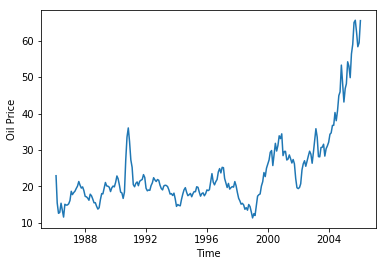

In [4]:
plt.xlabel('Time')
plt.ylabel('Oil Price')
plt.plot(dataset)
plt.show()

# Checking Stationary
## Rolling statistics
We could see that there the data is not stationary from the rolling statistics shown below

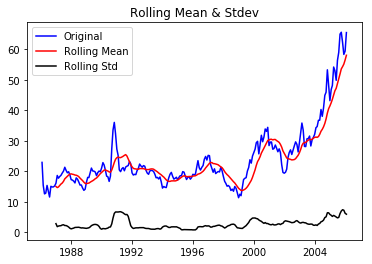

In [5]:
window = 12
rolmean = dataset.rolling(window=window).mean()
rolstd = dataset.rolling(window=window).std()

plt.plot(dataset, color = 'blue', label = 'Original')
plt.plot(rolmean, color = 'red', label= 'Rolling Mean')
plt.plot(rolstd, color = 'black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Stdev')
plt.show(block = False)

## Perform Dickey-Fuller Test

Since the p-value is larger than 0.5, and the Critical Values are less than the Test Statistics, we cannot reject the null hypthesis and the data is not stationary

In [6]:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(dataset['oil.price'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index = ['Test Statistics', 'p-value', '#Lags Used', '#Oberservations Used'])
for k,v in dftest[4].items():
    dfoutput['Critical Value (%s)'%k] = v

dfoutput

Results of Dickey-Fuller Test:


Test Statistics           1.490404
p-value                   0.997489
#Lags Used               15.000000
#Oberservations Used    225.000000
Critical Value (1%)      -3.459752
Critical Value (5%)      -2.874473
Critical Value (10%)     -2.573663
dtype: float64

## Estimating the Trend

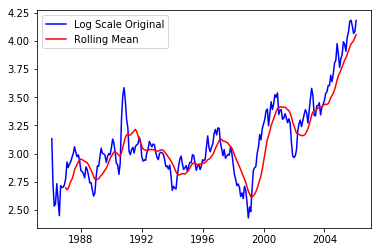

In [7]:
dataset_logscale = np.log(dataset)

window = 12
rolmean_logscale = dataset_logscale.rolling(window=window).mean()
rolstd_logscale = dataset_logscale.rolling(window=window).std()

plt.plot(dataset_logscale, color = 'blue', label = 'Log Scale Original')
plt.plot(rolmean_logscale, color = 'red', label= 'Rolling Mean')
plt.legend(loc='best')
plt.show()

In [8]:
dataset_logscale_minus_log_ma = dataset_logscale - rolmean_logscale
dataset_logscale_minus_log_ma.dropna(inplace=True)

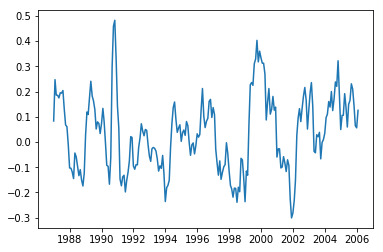

In [9]:
plt.plot(dataset_logscale_minus_log_ma)
plt.show()

In [10]:
def test_stationary(time_series):
    print('Performing Moving average test')
    window = 12
    rolmean = time_series.rolling(window=window).mean()
    rolstd = time_series.rolling(window=window).std()

    plt.plot(time_series, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Stdev')
    plt.show(block=False)

    print('Performing Dickey-Fuller Test')
    from statsmodels.tsa.stattools import adfuller
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(time_series['oil.price'], autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=[
                         'Test Statistics', 'p-value', '#Lags Used', '#Oberservations Used'])
    for k, v in dftest[4].items():
        dfoutput['Critical Value (%s)' % k] = v
    print(dfoutput)


Performing Moving average test


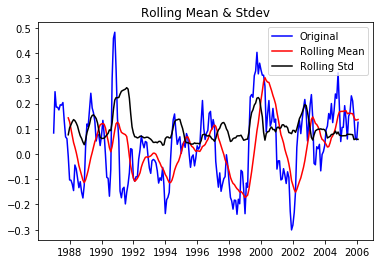

Performing Dickey-Fuller Test
Results of Dickey-Fuller Test:
Test Statistics          -5.057643
p-value                   0.000017
#Lags Used                1.000000
#Oberservations Used    228.000000
Critical Value (1%)      -3.459361
Critical Value (5%)      -2.874302
Critical Value (10%)     -2.573571
dtype: float64


In [11]:
test_stationary(dataset_logscale_minus_log_ma)

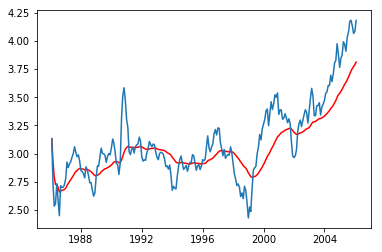

In [12]:
dataset_logscale_edwa = dataset_logscale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(dataset_logscale_edwa, color = 'red')
plt.plot(dataset_logscale)
plt.show()

Performing Moving average test


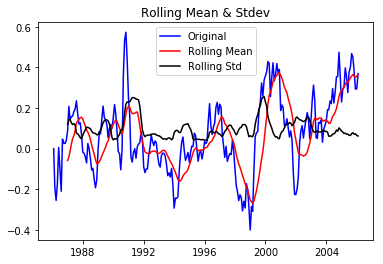

Performing Dickey-Fuller Test
Results of Dickey-Fuller Test:
Test Statistics          -4.001287
p-value                   0.001404
#Lags Used                1.000000
#Oberservations Used    239.000000
Critical Value (1%)      -3.458011
Critical Value (5%)      -2.873710
Critical Value (10%)     -2.573256
dtype: float64


In [13]:
dataset_logscale_edwa_minus_log_scale = dataset_logscale - dataset_logscale_edwa
test_stationary(dataset_logscale_edwa_minus_log_scale)

Performing Moving average test


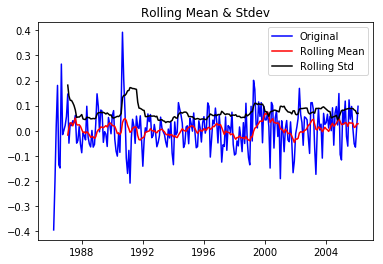

Performing Dickey-Fuller Test
Results of Dickey-Fuller Test:
Test Statistics        -8.273460e+00
p-value                 4.724887e-13
#Lags Used              3.000000e+00
#Oberservations Used    2.360000e+02
Critical Value (1%)    -3.458366e+00
Critical Value (5%)    -2.873866e+00
Critical Value (10%)   -2.573339e+00
dtype: float64


In [14]:
dataset_logscale_minus_logscale_shift = dataset_logscale.diff()
dataset_logscale_minus_logscale_shift.dropna(inplace=True)
test_stationary(dataset_logscale_minus_logscale_shift)

## Estimating then Components 

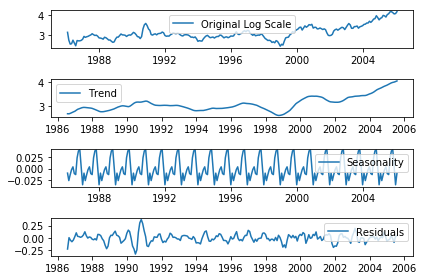

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dataset_logscale)
trend =decomposition.trend
seasonal =decomposition.seasonal
residual =decomposition.resid

plt.subplot(411)
plt.plot(dataset_logscale, label = 'Original Log Scale')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Performing Moving average test


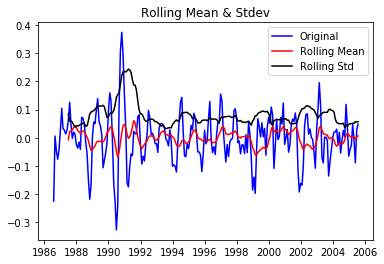

Performing Dickey-Fuller Test
Results of Dickey-Fuller Test:
Test Statistics        -1.119180e+01
p-value                 2.358883e-20
#Lags Used              3.000000e+00
#Oberservations Used    2.250000e+02
Critical Value (1%)    -3.459752e+00
Critical Value (5%)    -2.874473e+00
Critical Value (10%)   -2.573663e+00
dtype: float64


In [16]:
dataset_logscale_res = residual.dropna()
test_stationary(dataset_logscale_res)

# ARIMA
To calculate the value of P  and Q, we need to plot the ACF and PACF respectively.

In [17]:
from statsmodels.tsa.stattools import acf, pacf

In [18]:
lags = 20
lag_acf = acf(dataset_logscale_minus_logscale_shift, nlags = lags)
lag_pacf = pacf(dataset_logscale_minus_logscale_shift, nlags = lags, method = 'ols')

/home/dh/anaconda3/envs/domainAdaptation/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


## Plot ACF and PACF

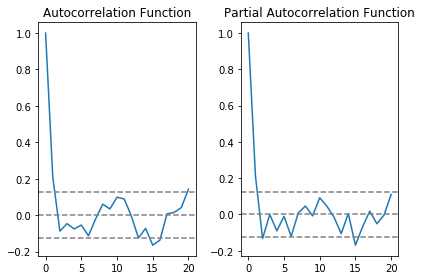

In [19]:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dataset_logscale_minus_logscale_shift)), linestyle = '--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataset_logscale_minus_logscale_shift)), linestyle = '--', color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dataset_logscale_minus_logscale_shift)), linestyle = '--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataset_logscale_minus_logscale_shift)), linestyle = '--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Plotting AR model
                             ARIMA Model Results                              
Dep. Variable:            D.oil.price   No. Observations:                  240
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 260.468
Method:                       css-mle   S.D. of innovations              0.082
Date:                Thu, 29 Aug 2019   AIC                           -514.936
Time:                        21:05:38   BIC                           -504.494
Sample:                    02-28-1986   HQIC                          -510.729
                         - 01-31-2006                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0041      0.007      0.595      0.553      -0.009       0.017
ma.L1.D.oil.price     0.2939      0.070      4.226      0.000       0.158       0.430
      

/home/dh/anaconda3/envs/domainAdaptation/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/home/dh/anaconda3/envs/domainAdaptation/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


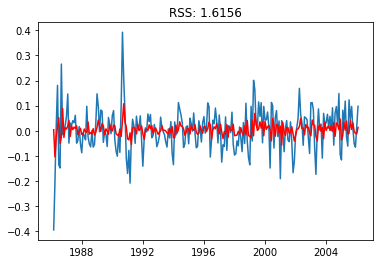

In [20]:
from statsmodels.tsa.arima_model import ARIMA
P = 0
D = 1
Q = 1

#Auto Regression Model
model = ARIMA(dataset_logscale, order = (P,D,Q))
results_AR = model.fit(disp = -1)
plt.plot(dataset_logscale_minus_logscale_shift)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - dataset_logscale_minus_logscale_shift['oil.price'])**2))
print('Plotting AR model')
print(results_AR.summary())

/home/dh/anaconda3/envs/domainAdaptation/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/home/dh/anaconda3/envs/domainAdaptation/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


Plotting MA model
                             ARIMA Model Results                              
Dep. Variable:            D.oil.price   No. Observations:                  240
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 258.717
Method:                       css-mle   S.D. of innovations              0.082
Date:                Thu, 29 Aug 2019   AIC                           -511.434
Time:                        21:05:38   BIC                           -500.992
Sample:                    02-28-1986   HQIC                          -507.227
                         - 01-31-2006                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0040      0.007      0.575      0.566      -0.010       0.018
ar.L1.D.oil.price     0.2337      0.066      3.536      0.000       0.104       0.363
      

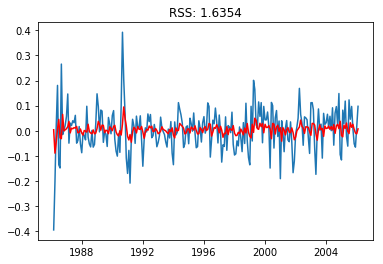

In [21]:
P = 1
D = 1
Q = 0

#Moving Average Model
model = ARIMA(dataset_logscale, order = (P,D,Q))
results_MA = model.fit(disp = -1)
plt.plot(dataset_logscale_minus_logscale_shift)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues - dataset_logscale_minus_logscale_shift['oil.price'])**2))
print('Plotting MA model')
print(results_MA.summary())

/home/dh/anaconda3/envs/domainAdaptation/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/home/dh/anaconda3/envs/domainAdaptation/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


Plotting ARIMA model
                             ARIMA Model Results                              
Dep. Variable:            D.oil.price   No. Observations:                  240
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 261.352
Method:                       css-mle   S.D. of innovations              0.081
Date:                Thu, 29 Aug 2019   AIC                           -510.704
Time:                        21:05:39   BIC                           -489.820
Sample:                    02-28-1986   HQIC                          -502.289
                         - 01-31-2006                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0041      0.006      0.648      0.518      -0.008       0.017
ar.L1.D.oil.price    -0.5967      1.137     -0.525      0.600      -2.825       1.631
ar.

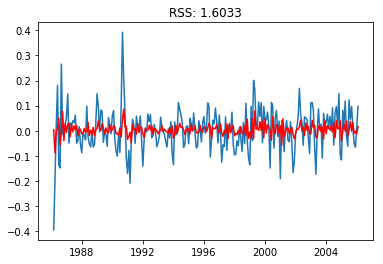

In [22]:
P = 2
D = 1
Q = 2

model = ARIMA(dataset_logscale, order = (P,D,Q))
results_ARIMA = model.fit(disp = -1)
plt.plot(dataset_logscale_minus_logscale_shift)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues - dataset_logscale_minus_logscale_shift['oil.price'])**2))
print('Plotting ARIMA model')
print(results_ARIMA.summary())

## Predictions

/home/dh/anaconda3/envs/domainAdaptation/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


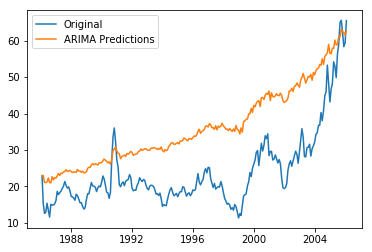

In [23]:
predicitons_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy = True)
predicitons_ARIMA_diff_cumsum = predicitons_ARIMA_diff.cumsum()

predicitons_ARIMA_log = pd.Series(dataset_logscale['oil.price'].ix[0], index=dataset_logscale.index)
predicitons_ARIMA_log = predicitons_ARIMA_log.add(predicitons_ARIMA_diff_cumsum, fill_value = 0)

predictions_ARIMA = np.exp(predicitons_ARIMA_log)
plt.plot(dataset, label = 'Original')
plt.plot(predictions_ARIMA, label='ARIMA Predictions')
plt.legend(loc='best')
plt.show()

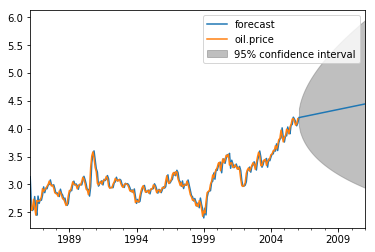

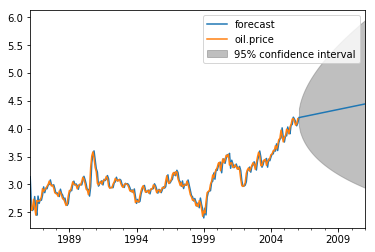

In [24]:
results_ARIMA.plot_predict(1,300)

In [25]:
results_ARIMA.forecast(steps=120)

(array([4.20394837, 4.20382516, 4.20944559, 4.21296979, 4.21740242,
        4.22141795, 4.2256282 , 4.22974713, 4.23390895, 4.23805061,
        4.24220175, 4.24634843, 4.25049721, 4.254645  , 4.25879326,
        4.2629413 , 4.26708944, 4.27123753, 4.27538565, 4.27953375,
        4.28368186, 4.28782997, 4.29197808, 4.29612618, 4.30027429,
        4.3044224 , 4.30857051, 4.31271862, 4.31686672, 4.32101483,
        4.32516294, 4.32931105, 4.33345916, 4.33760727, 4.34175537,
        4.34590348, 4.35005159, 4.3541997 , 4.35834781, 4.36249591,
        4.36664402, 4.37079213, 4.37494024, 4.37908835, 4.38323645,
        4.38738456, 4.39153267, 4.39568078, 4.39982889, 4.40397699,
        4.4081251 , 4.41227321, 4.41642132, 4.42056943, 4.42471753,
        4.42886564, 4.43301375, 4.43716186, 4.44130997, 4.44545807,
        4.44960618, 4.45375429, 4.4579024 , 4.46205051, 4.46619861,
        4.47034672, 4.47449483, 4.47864294, 4.48279105, 4.48693915,
        4.49108726, 4.49523537, 4.49938348, 4.50

In [26]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})